In [ ]:
!nvidia-smi

Fri Sep 22 11:22:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |    741MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 printing the current dircetory name

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/datasets


importing necessay libraries

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
roboflow: 1.1.6 ; supervision: 0.3.0 ; transformers: 4.33.2 ; pytorch_lightning: 2.0.9


In [ ]:
%cd {HOME}
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

/content/datasets
--2023-09-22 11:23:02--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2023-09-22 11:23:02 (107 MB/s) - ‘dog.jpeg’ saved [106055/106055]



loadign dog iamge

In [ ]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

loading pretrained DETR model with the resnet 50 as the backbone

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

object detection using the DETR Model

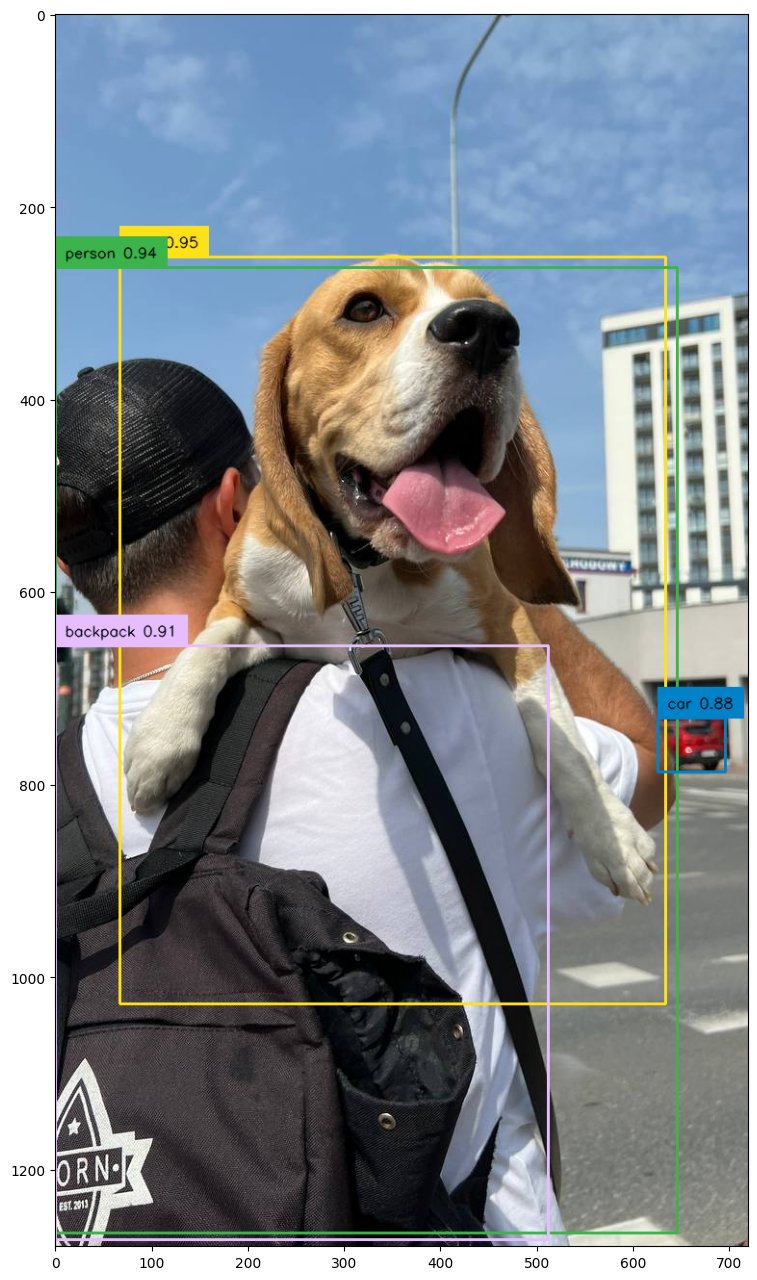

In [ ]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread(IMAGE_PATH)
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

Here on words, Our main code for the object detection for the EDI Will begin

Here we are using Roboflow API private key for loading the dataset tah twe have annotated on it

In [ ]:
from getpass import getpass
ROBOFLOW_API_KEY = getpass('Enter ROBOFLOW_API_KEY secret value: ')

Enter ROBOFLOW_API_KEY secret value: ··········


loading dataset

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UMnC0JXV2jFt2UbZ69GJ")
project = rf.workspace("vishwakarma-institute-of-technology-og9wd").project("car-dp4on")
dataset = project.version(1).download("coco")

/content/datasets/datasets
loading Roboflow workspace...
loading Roboflow project...




Extracting Dataset Version Zip to car-1 in coco:: 100%|██████████| 320/320 [00:00<00:00, 4360.51it/s]


daatabase location

In [ ]:
dataset.location

'/content/datasets/datasets/car-1'

checking all the necessary requirements are satisfied or not. Displaying total number of images persent in the database,tarining images and testing images

In [ ]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 219
Number of validation examples: 62
Number of test examples: 31


selecting and displaying random image form the database

Image #111


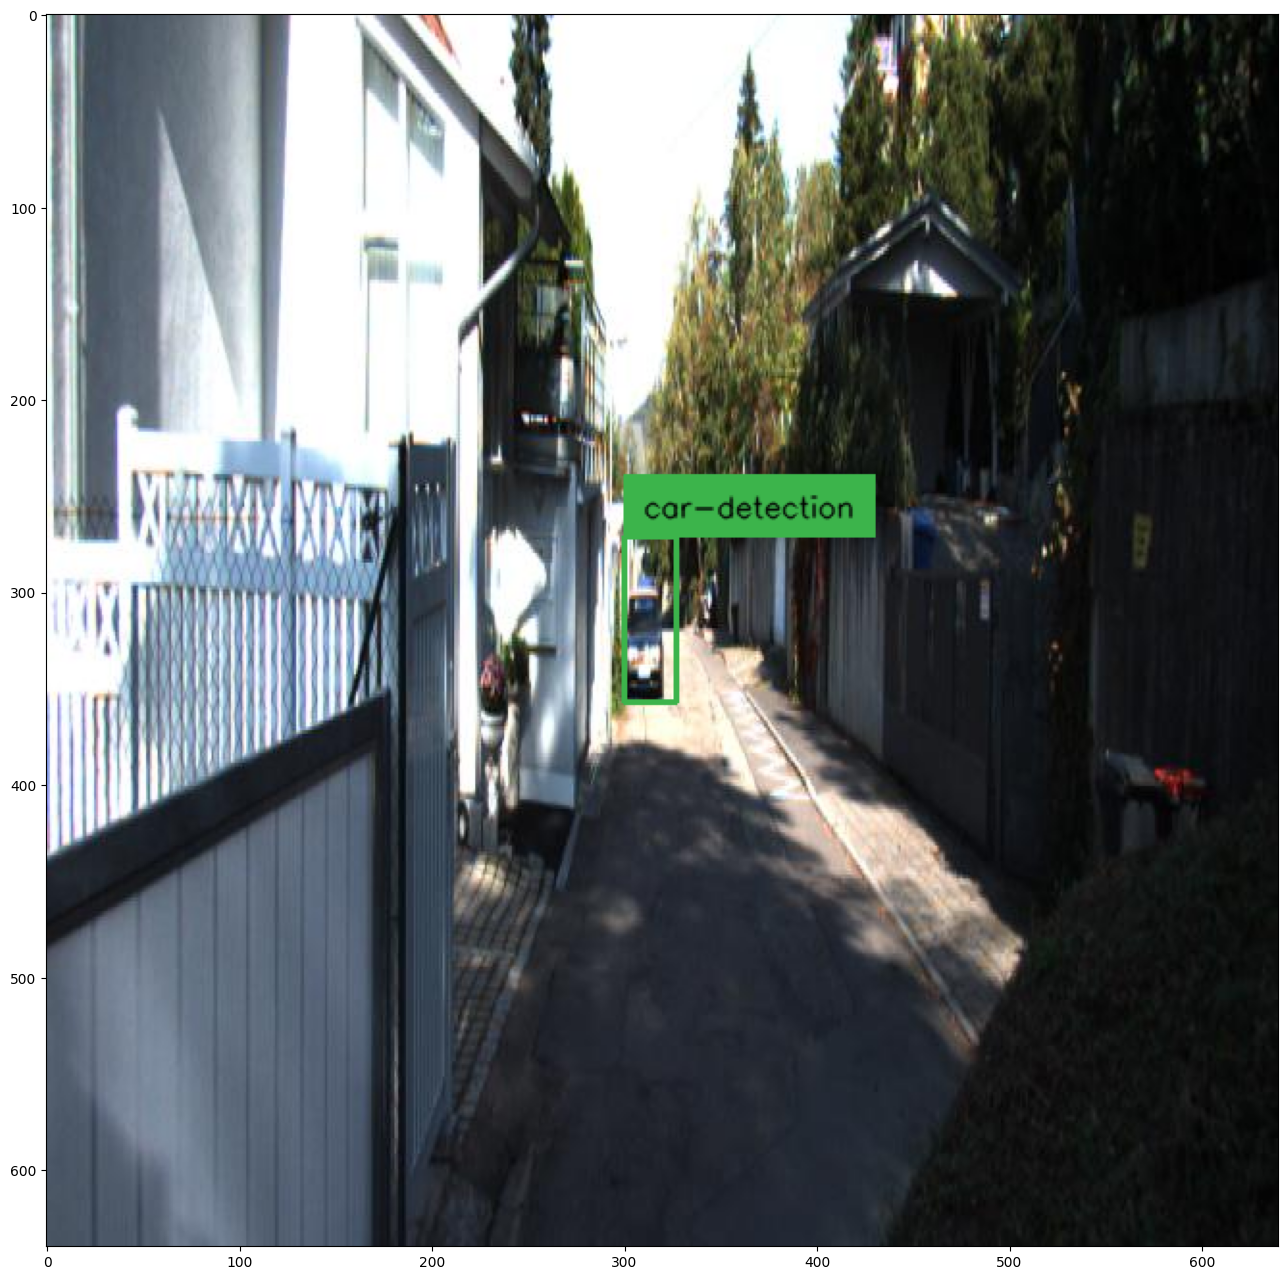

In [ ]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

dataloader

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)


**Main code for the DETR Encoder and Decoder architucture**

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import DetrForObjectDetection

# Define your custom encoder block
class CustomEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=8, hidden_dim=2048, num_layers=1):
        super(CustomEncoderBlock, self).__init__()
        # Implement your encoder block here
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = torch.relu(out)
        return out

# Define your custom decoder block
class CustomDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=8, hidden_dim=2048, num_layers=1):
        super(CustomDecoderBlock, self).__init__()
        # Implement your decoder block here
        self.self_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(out_channels)
        self.cross_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(out_channels)
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_channels)
        )

    def forward(self, x, encoder_output):
        self_attn_output, _ = self.self_attention(x, x, x)
        x = x + self_attn_output
        x = self.norm1(x)

        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output)
        x = x + cross_attn_output
        x = self.norm2(x)

        ffn_output = self.ffn(x)
        x = x + ffn_output

        return x

# Create a custom DETR model
class CustomDetrForObjectDetection(DetrForObjectDetection):
    def __init__(self, config, custom_encoder, custom_decoder):
        super().__init__(config)
        self.encoder = custom_encoder
        self.decoder = custom_decoder

# Define your Lightning module using the custom DETR model
class CustomDetr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay, custom_encoder, custom_decoder):
        super().__init__()
        self.model = CustomDetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",  # Example model identifier
            custom_encoder=custom_encoder,
            custom_decoder=custom_decoder,
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER  # Replace with your training data loader

    def val_dataloader(self):
        return VAL_DATALOADER  # Replace with your validation data loader

# Create an instance of your custom encoder and decoder
custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)



#--------------------------------------------------------------------------------------------------#
# Define your training and validation data loaders (TRAIN_DATALOADER and VAL_DATALOADER)
# and then train your custom DETR model as before.

# To train your model, you should define TRAIN_DATALOADER and VAL_DATALOADER with your dataset and data loaders.
# Replace them with your actual data loaders for training and validation.

from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)


custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)

# Initialize a PyTorch Lightning Trainer
# Initialize a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=10,  # Set the number of training epochs
    num_sanity_val_steps=0,  # Set to 0 to skip initial validation check
)

# Create an instance of your custom encoder and decoder
custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)

# Train the custom DETR model
trainer.fit(custom_detr_model)


Some weights of CustomDetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['decoder.self_attention.out_proj.bias', 'encoder.norm2.weight', 'decoder.self_attention.in_proj_bias', 'decoder.cross_attention.out_proj.bias', 'decoder.norm1.weight', 'decoder.norm1.bias', 'encoder.conv1.bias', 'decoder.self_attention.in_proj_weight', 'encoder.norm1.bias', 'decoder.cross_attention.in_proj_bias', 'encoder.norm2.bias', 'encoder.conv2.bias', 'decoder.self_attention.out_proj.weight', 'decoder.ffn.2.weight', 'decoder.ffn.0.weight', 'encoder.conv1.weight', 'decoder.norm2.bias', 'decoder.cross_attention.out_proj.weight', 'decoder.ffn.0.bias', 'decoder.cross_attention.in_proj_weight', 'encoder.conv2.weight', 'decoder.norm2.weight', 'decoder.ffn.2.bias', 'encoder.norm1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomDetrForObjectDetection w

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


#
#
In this section of the code i take the imae for the dataset that is selected randomly
#
#

Not working code

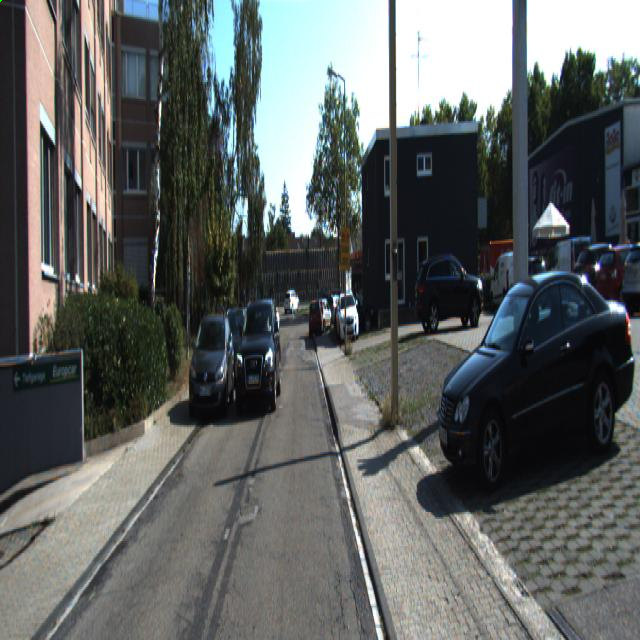

In [ ]:
import cv2
import torch
from PIL import Image
import numpy as np
from transformers import DetrImageProcessor
from google.colab.patches import cv2_imshow  # Use cv2_imshow for displaying images in Colab

# Load the input image
input_image_path = '/content/007209_png.rf.9bf0cebf807024db43f73a29a5db9f8e.jpg'
input_image = cv2.imread(input_image_path)

# Check if the image was loaded successfully
if input_image is None:
    raise ValueError(f"Failed to load the image at path: {input_image_path}")

# Initialize the image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Convert the input image to PIL format
input_image_pil = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# Preprocess the input image
inputs = image_processor(images=input_image_pil, return_tensors="pt")

# Use the model to make predictions
with torch.no_grad():
    outputs = custom_detr_model(**inputs)

# Post-process the model's predictions
post_processed_output = image_processor.post_process_object_detection(outputs, threshold=0.2)  # Adjust the threshold as needed

# Draw bounding boxes on the input image
for prediction in post_processed_output:
    for score, label, box in zip(prediction["scores"], prediction["labels"], prediction["boxes"]):
        if score > 0.2:  # Adjust the confidence threshold as needed
            box = [int(b) for b in box]  # Convert to integer coordinates
            input_image = cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)  # Draw a green bounding box

# Display the image with bounding boxes using cv2_imshow
cv2_imshow(input_image)


**In this code i able to make the perdiction on the image which is not present in the given dataset**

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


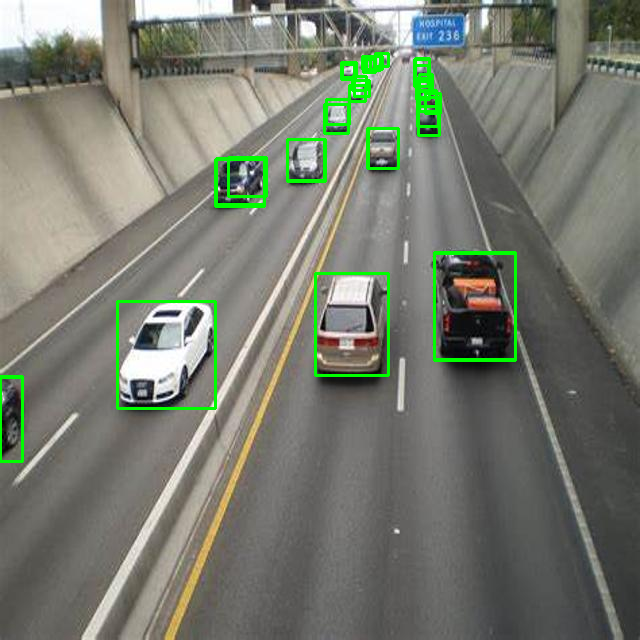

In [79]:
import cv2
import torch
from PIL import Image
import numpy as np
from transformers import DetrImageProcessor, DetrForObjectDetection
from google.colab.patches import cv2_imshow

# Load the input image
input_image_path = '/content/re2.jpg'
input_image = cv2.imread(input_image_path)

# Check if the image was loaded successfully
if input_image is None:
    raise ValueError(f"Failed to load the image at path: {input_image_path}")

# Initialize the image processor and model
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Convert the input image to PIL format
input_image_pil = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# Preprocess the input image
inputs = image_processor(images=input_image_pil, return_tensors="pt")

# Use the model to make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the model's predictions
target_sizes = torch.tensor([input_image_pil.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Draw bounding boxes on the input image
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if score > 0.2:  # Adjust the confidence threshold as needed
        box = [int(b) for b in box]  # Convert to integer coordinates
        input_image = cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)  # Draw a green bounding box

# Display the image with bounding boxes using cv2_imshow
cv2_imshow(input_image)


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


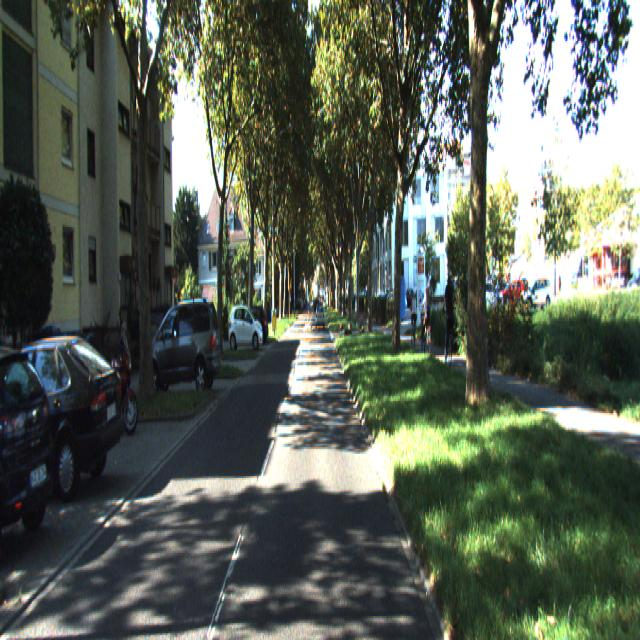

In [86]:
import cv2
import torch
from PIL import Image
import numpy as np
from transformers import DetrImageProcessor, DetrForObjectDetection
from google.colab.patches import cv2_imshow

# Load the input image
input_image_path = '/content/007021_png.rf.b2e7be8354ef07c9a29dcfe15a762e95.jpg'
input_image = cv2.imread(input_image_path)

# Check if the image was loaded successfully
if input_image is None:
    raise ValueError(f"Failed to load the image at path: {input_image_path}")

# Initialize the image processor and model
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Convert the input image to PIL format
input_image_pil = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# Preprocess the input image
inputs = image_processor(images=input_image_pil, return_tensors="pt")

# Use the model to make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the model's predictions
target_sizes = torch.tensor([input_image_pil.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Define a list of class labels (you may need to adjust this based on your model's classes)
class_labels = ["sign", "car-detection"]  # Replace with your class labels

# Draw bounding boxes on the input image with labels
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if score > 0.2:  # Adjust the confidence threshold as needed
        box = [int(b) for b in box]  # Convert to integer coordinates
        if label < len(class_labels):
            class_name = class_labels[label]
            label_text = f"{class_name}: {score:.2f}"
            input_image = cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            input_image = cv2.putText(input_image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            print(f"Warning: Label index {label} is out of range of class_labels.")

# Display the image with bounding boxes and labels using cv2_imshow
cv2_imshow(input_image)


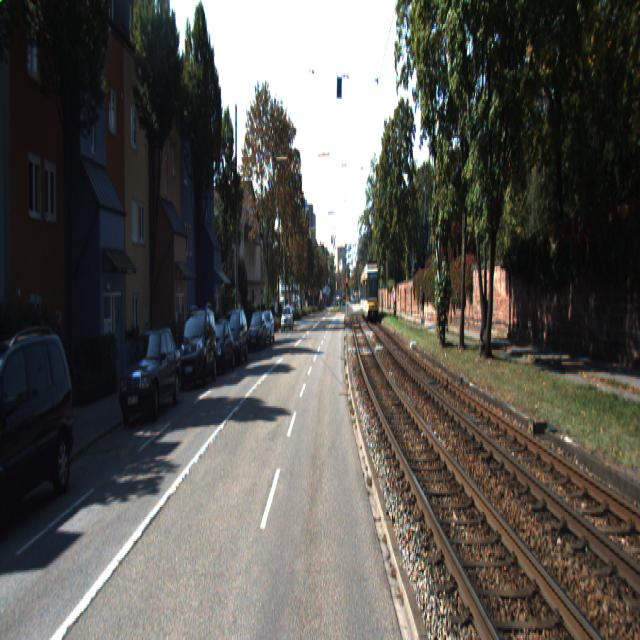

In [ ]:
import cv2
import torch
import numpy as np
from transformers import DetrImageProcessor
from google.colab.patches import cv2_imshow  # Use cv2_imshow for displaying images in Colab

# Load the input image
input_image_path = '/content/007039_png.rf.34883711f9bdc9a146727fa85baa61d0.jpg'
input_image = cv2.imread(input_image_path)

# Check if the image was loaded successfully
if input_image is None:
    raise ValueError(f"Failed to load the image at path: {input_image_path}")

# Initialize the image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Convert the input image to PIL format
input_image_pil = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# Preprocess the input image
inputs = image_processor(images=input_image_pil, return_tensors="pt")

# Use the model to make predictions
with torch.no_grad():
    outputs = custom_detr_model(**inputs)

# Post-process the model's predictions
post_processed_output = image_processor.post_process_object_detection(outputs, threshold=0.2)  # Adjust the threshold as needed

# Draw bounding boxes on the input image
for prediction in post_processed_output:
    for score, label, box in zip(prediction["scores"], prediction["labels"], prediction["boxes"]):
        if score > 0.2:  # Adjust the confidence threshold as needed
            box = [int(b) for b in box]  # Convert to integer coordinates
            label_text = f"Label: {label}, Score: {score:.2f}"  # Create label text
            # Draw the bounding box
            input_image = cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            # Put the label text above the bounding box
            input_image = cv2.putText(input_image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes and labels using cv2_imshow
cv2_imshow(input_image)


In [ ]:
import torch

# Function to calculate IoU (Jaccard Index) between two bounding boxes
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    iou = intersection / union if union > 0 else 0.0
    return iou

# Function to calculate accuracy
def calculate_accuracy(model, dataloader, iou_threshold=0.5, confidence_threshold=0.2):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"]
            pixel_mask = batch["pixel_mask"]
            labels = batch["labels"]

            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            # Post-process the model outputs
            post_processed_output = image_processor.post_process_object_detection(outputs, threshold=confidence_threshold)

            # Calculate accuracy for this batch
            for preds, targets in zip(post_processed_output, labels):
                total_samples += 1
                if len(preds['labels']) == 0:
                    continue
                pred_boxes = preds['boxes']

                # Loop through ground truth boxes for this example
                correct_preds = False
                for target_box in targets['boxes']:
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes]
                    if any(iou >= iou_threshold for iou in ious):
                        correct_preds = True
                        break  # Exit the loop if a correct prediction is found

                total_correct += int(correct_preds)

    # Calculate accuracy
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return accuracy

# Assuming you have a validation dataloader (VAL_DATALOADER)
val_accuracy = calculate_accuracy(custom_detr_model, VAL_DATALOADER)
print("Validation Accuracy:", val_accuracy)

# If you have a test dataloader, you can calculate accuracy on the test set in a similar way.


Validation Accuracy: 0.0


Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box: [0, 0, 0, 0]
Drawing bounding box

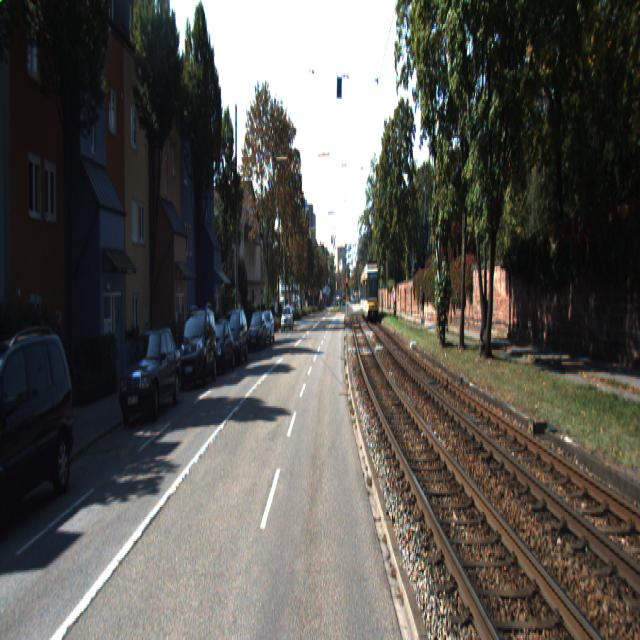

True

In [ ]:
import cv2
import torch
from PIL import Image
import numpy as np
from transformers import DetrImageProcessor
from google.colab.patches import cv2_imshow

# Load the input image
input_image_path = '/content/007039_png.rf.34883711f9bdc9a146727fa85baa61d0.jpg'
input_image = cv2.imread(input_image_path)

# Check if the image was loaded successfully
if input_image is None:
    raise ValueError(f"Failed to load the image at path: {input_image_path}")

# Initialize the image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Convert the input image to RGB format
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image_pil = Image.fromarray(input_image_rgb)

# Preprocess the input image
inputs = image_processor(images=input_image_pil, return_tensors="pt")

# Use the model to make predictions
with torch.no_grad():
    outputs = custom_detr_model(**inputs)

# Post-process the model's predictions
post_processed_output = image_processor.post_process_object_detection(outputs, threshold=0.2)

# Draw bounding boxes on the input image
for prediction in post_processed_output:
    for score, label, box in zip(prediction["scores"], prediction["labels"], prediction["boxes"]):
        if score > 0.2:
            box = [int(b) for b in box]
            print("Drawing bounding box:", box)
            input_image = cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

# Display the image with bounding boxes using cv2_imshow
cv2_imshow(input_image)

# Save the image with bounding boxes
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, input_image)


In [ ]:
# Load the saved model
loaded_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                          custom_encoder=custom_encoder, custom_decoder=custom_decoder)

checkpoint = torch.load(model_save_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Now loaded_model contains the trained weights and can be used for inference or further training.


Some weights of CustomDetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['decoder.self_attention.out_proj.bias', 'encoder.norm2.weight', 'decoder.self_attention.in_proj_bias', 'decoder.cross_attention.out_proj.bias', 'decoder.norm1.weight', 'decoder.norm1.bias', 'encoder.conv1.bias', 'decoder.self_attention.in_proj_weight', 'encoder.norm1.bias', 'decoder.cross_attention.in_proj_bias', 'encoder.norm2.bias', 'encoder.conv2.bias', 'decoder.self_attention.out_proj.weight', 'decoder.ffn.2.weight', 'decoder.ffn.0.weight', 'encoder.conv1.weight', 'decoder.norm2.bias', 'decoder.cross_attention.out_proj.weight', 'decoder.ffn.0.bias', 'decoder.cross_attention.in_proj_weight', 'encoder.conv2.weight', 'decoder.norm2.weight', 'decoder.ffn.2.bias', 'encoder.norm1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>